In [1]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
setup_google_colab.setup_week2()
setup_google_colab.setup_week2_honor()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

--2020-12-14 14:44:21--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-12-14 14:44:21 (56.2 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.tar.gz
**************************************************
mnist.npz
**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
*******************************************

In [2]:
import os
import subprocess
import json
import time
import requests
from functools import wraps
import traceback
import math


def download_github_code(path):
    filename = path.rsplit("/")[-1]
    os.system("shred -u {}".format(filename))
    os.system("wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/{} -O {}".format(path, filename))
    
    
def setup_common():
    if bool(int(os.environ.get("EXPERIMENTAL_TQDM", "0"))):
        os.system("pip install --force https://github.com/hse-aml/intro-to-dl/releases/download/ColabTqdm/tqdm-colab.zip")
    else:
        os.system("pip install tqdm")
    download_github_code("keras_utils.py")
    download_github_code("grading.py")
    download_github_code("download_utils.py")
    download_github_code("tqdm_utils.py")

    
def retry(ExceptionToCheck, tries=4, delay=3, backoff=2):
    def deco_retry(f):

        @wraps(f)
        def f_retry(*args, **kwargs):
            mtries, mdelay = tries, delay
            while mtries > 1:
                try:
                    return f(*args, **kwargs)
                except KeyboardInterrupt as e:
                    raise e
                except ExceptionToCheck as e:
                    print("%s, retrying in %d seconds..." % (str(e), mdelay))
                    traceback.print_exc()
                    time.sleep(mdelay)
                    mtries -= 1
                    mdelay *= backoff
            return f(*args, **kwargs)

        return f_retry  # true decorator

    return deco_retry

@retry(Exception)
def download_file(url, file_path):
    import tqdm_utils
    r = requests.get(url, stream=True)
    total_size = int(r.headers.get('content-length'))
    bar = tqdm_utils.tqdm_notebook_failsafe(total=total_size, unit='B', unit_scale=True)
    bar.set_description(os.path.split(file_path)[-1])
    incomplete_download = False
    try:
        with open(file_path, 'wb', buffering=16 * 1024 * 1024) as f:
            for chunk in r.iter_content(4 * 1024 * 1024):
                f.write(chunk)
                bar.update(len(chunk))
    except Exception as e:
        raise e
    finally:
        bar.close()
        if os.path.exists(file_path) and os.path.getsize(file_path) != total_size:
            incomplete_download = True
            os.remove(file_path)
    if incomplete_download:
        raise Exception("Incomplete download")
    
def download_from_github(version, fn, target_dir):
    url = "https://github.com/hse-aml/intro-to-dl/releases/download/{0}/{1}".format(version, fn)
    file_path = os.path.join(target_dir, fn)
    download_file(url, file_path)


def sequential_downloader(version, fns, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for fn in fns:
        download_from_github(version, fn, target_dir)

    

def setup_week2_honor():
    setup_common()
    download_github_code("week2/preprocessed_mnist.py")
    download_github_code("week2/util.py")

setup_week2_honor()

### Your very own neural network

In this notebook we're going to build a neural network using naught but pure numpy and steel nerves. It's going to be fun, I promise!

<img src="https://github.com/alexeybevz/intro-to-dl/blob/master/week2/frankenstein.png?raw=1" style="width:20%">

In [3]:
import sys
sys.path.append("..")
import tqdm_utils
import download_utils

In [4]:
# use the preloaded keras datasets and models
download_utils.link_all_keras_resources()

In [5]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

Here goes our main class: a layer that can do .forward() and .backward() passes.

In [6]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### The road ahead

We're going to build a neural network that classifies MNIST digits. To do so, we'll need a few building blocks:
- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (or any other nonlinearity you want)
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

Нелинейная функция. Функция активации - определяет выход нейросети. Дает возможность выражать нелийные преобразования.

Одна из: ReLU (0 - если число отрицательное, x - если число положительное), TanH, Sigmoid / Logistic, Leaky ReLU, Softmax, Swish, ...

Для себя: есть X и W. 1-я итерация, каждый X умножаем на W1, суммируем. К полученному значению применяем нелинейную функцию. Получили значение для 1-го нейрона. 2-я итерация, каждый X умножаем на W2, ... Получили значение 2-го нейрона. Прогнали первый слой, который является входом для следующего. Взяли новое значение, умножили на вес, применили функцию и т.д.

Такие слои называются полносвязными (fully-connected). Слои, которым на вход каждого нейрона приходит значение всех нейронов прошлого слоя.

прямой проход - посчитать loss, обратный проход - посчитать градиент

Обратное распространение направлено на минимизацию функции потерь путем корректировки весов и смещений сети. Степень корректировки определяется градиентами функции потерь по отношению к этим параметрам.

Производная функции С отражает чувствительность к изменению значения функции (выходного значения) относительно изменения ее аргумента х (входного значения). Другими словами, производная говорит нам в каком направлении движется С.

Градиент показывает, насколько необходимо изменить параметр x (в положительную или отрицательную сторону), чтобы минимизировать С.

Вычисление этих градиентов происходит с помощью метода, называемого цепным правилом.

In [7]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        inp = input.copy()
        # <your code. Try np.maximum>
        #for i_inp, v_inp in enumerate(inp):
        #  for i_row, v_row in enumerate(v_inp):
        #    inp[i_inp][i_row] = np.maximum(v_row, 0)
        #return inp
        return np.maximum(0, inp)
    
    # grad_output - градиент функции ошибки
    # Необходимо вычислить градиент для каждого X
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad        

In [8]:
test = ReLU()
print(test.forward([[-1,0], [2, -1]]))

[[0 0]
 [2 0]]


In [9]:
# some tests
from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

#### Instant primer: lambda functions

In python, you can define functions in one line using the `lambda` syntax: `lambda param1, param2: expression`

For example: `f = lambda x, y: x+y` is equivalent to a normal function:

```
def f(x,y):
    return x+y
```
For more information, click [here](http://www.secnetix.de/olli/Python/lambda_functions.hawk).    

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [10]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1, optimization='default', use_adaptive_lrate = False):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)

        #adam
        self.first_moment = 0
        self.second_moment = 0
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.opt = optimization

        #learning rate scheduler
        self.drop = 0.5
        self.epochs_drop = 10.0
        self.use_adaptive_lrate = use_adaptive_lrate
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self,input,grad_output,epoch=0):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        if self.opt == 'adam':
            # Step-based learning schedules
            if self.use_adaptive_lrate:
                adptv_lrate = self.learning_rate * math.pow(self.drop, math.floor((1 + epoch) / self.epochs_drop))
            else:
                adptv_lrate = self.learning_rate
            
            self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * grad_weights
            self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * grad_weights * grad_weights
            first_unbias = self.first_moment / (1 - self.beta1 ** epoch)
            second_unbias = self.second_moment / (1 - self.beta2 ** epoch)
            self.weights = self.weights - adptv_lrate * first_unbias / (np.sqrt(second_unbias) + 10 ** -7)
        else:
            self.weights = self.weights - self.learning_rate * grad_weights

        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### Testing the dense layer

Here we have a few tests to make sure your dense layer works properly. You can just run them, get 3 "well done"s and forget they ever existed.

... or not get 3 "well done"s and go fix stuff. If that is the case, here are some tips for you:
* Make sure you compute gradients for W and b as __sum of gradients over batch__, not mean over gradients. Grad_output is already divided by batch size.
* If you're debugging, try saving gradients in class fields, like "self.grad_w = grad_w" or print first 3-5 weights. This helps debugging.
* If nothing else helps, try ignoring tests and proceed to network training. If it trains alright, you may be off by something that does not affect network training.

In [11]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [12]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [13]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

In [14]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [15]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."


### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

In [16]:
import tensorflow as tf


def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

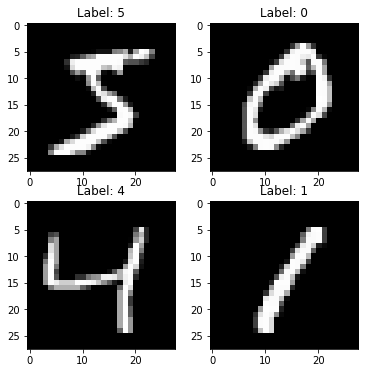

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [18]:
network = []
network.append(Dense(X_train.shape[1],100)) #100->10
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [19]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for layer in network:
      input = layer.forward(input)
      activations.append(input)
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y,epoch):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """

    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]

    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # <your code: propagate gradients through the network>
    loss_grad_bw = loss_grad
    for layer_ind in reversed(range(0, len(layer_activations[:-1]))):
        nl = network[layer_ind+1]
        if (type(nl) is Dense):
            loss_grad_bw = nl.backward(layer_activations[layer_ind], loss_grad_bw,epoch)
        else:
            loss_grad_bw = nl.backward(layer_activations[layer_ind], loss_grad_bw)

    return np.mean(loss)

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [20]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_utils.tqdm_notebook_failsafe(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [21]:
from IPython.display import clear_output
train_log = []
val_log = []

In [22]:
def train_epochs(num_epochs):
    train_log = []
    val_log = []

    for epoch in range(1, num_epochs):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
            train(network,x_batch,y_batch,epoch)
        
        train_log.append(np.mean(predict(network,X_train)==y_train))
        val_log.append(np.mean(predict(network,X_val)==y_val))
        
        clear_output()
        print("Epoch",epoch)
        print("Train accuracy:",train_log[-1])
        print("Val accuracy:",val_log[-1])
        plt.plot(train_log,label='train accuracy')
        plt.plot(val_log,label='val accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

Epoch 24
Train accuracy: 0.89362
Val accuracy: 0.9029


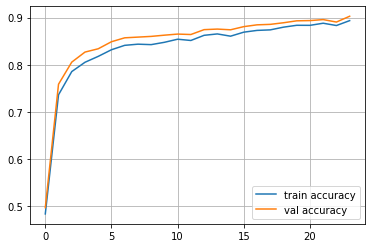

In [23]:
train_epochs(25)

### Peer-reviewed assignment

Congradulations, you managed to get this far! There is just one quest left undone, and this time you'll get to choose what to do.


#### Option I: initialization
* Implement Dense layer with Xavier initialization as explained [here](http://bit.ly/2vTlmaJ)

To pass this assignment, you must conduct an experiment showing how xavier initialization compares to default initialization on deep networks (5+ layers).


#### Option II: regularization
* Implement a version of Dense layer with L2 regularization penalty: when updating Dense Layer weights, adjust gradients to minimize

$$ Loss = Crossentropy + \alpha \cdot \underset i \sum {w_i}^2 $$

To pass this assignment, you must conduct an experiment showing if regularization mitigates overfitting in case of abundantly large number of neurons. Consider tuning $\alpha$ for better results.

#### Option III: optimization
* Implement a version of Dense layer that uses momentum/rmsprop or whatever method worked best for you last time.

Most of those methods require persistent parameters like momentum direction or moving average grad norm, but you can easily store those params inside your layers.

To pass this assignment, you must conduct an experiment showing how your chosen method performs compared to vanilla SGD.

### General remarks
_Please read the peer-review guidelines before starting this part of the assignment._

In short, a good solution is one that:
* is based on this notebook
* runs in the default course environment with Run All
* its code doesn't cause spontaneous eye bleeding
* its report is easy to read.

_Formally we can't ban you from writing boring reports, but if you bored your reviewer to death, there's noone left alive to give you the grade you want._


### Bonus assignments

As a bonus assignment (no points, just swag), consider implementing Batch Normalization ([guide](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b)) or Dropout ([guide](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)). Note, however, that those "layers" behave differently when training and when predicting on test set.

* Dropout:
  * During training: drop units randomly with probability __p__ and multiply everything by __1/(1-p)__
  * During final predicton: do nothing; pretend there's no dropout
  
* Batch normalization
  * During training, it substracts mean-over-batch and divides by std-over-batch and updates mean and variance.
  * During final prediction, it uses accumulated mean and variance.


In [24]:
class SigmoidLayer():
    def __init__(self):
        pass

    def sigmoid(self, x):
	    return 1 / (1 + np.exp(-x))
     
    def sigmoid_dx(self, x):
	    return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def forward(self, input):
        return self.sigmoid(input) #np.array([self.sigmoid(xw) for xw in inp])
    
    def backward(self, input, grad_output):
        return self.sigmoid_dx(input) * grad_output

In [25]:
network = []
network.append(Dense(X_train.shape[1],300,0.3))
network.append(SigmoidLayer())
network.append(Dense(300,200,0.2))
network.append(SigmoidLayer())
network.append(Dense(200,10,0.2))

In [26]:
#train_epochs(25)

### Adam

In [27]:
network = []
network.append(Dense(X_train.shape[1],100,0.1,'adam'))
network.append(ReLU())
network.append(Dense(100,200,0.1,'adam'))
network.append(ReLU())
network.append(Dense(200,10,0.1,'adam'))

Epoch 24
Train accuracy: 0.9477
Val accuracy: 0.9265


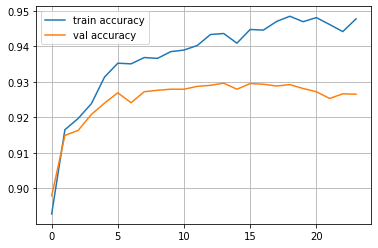

In [28]:
train_epochs(25)

### Adam + adaptive learning rate

In [29]:
network = []
network.append(Dense(X_train.shape[1],100,0.1,'adam',True))
network.append(ReLU())
network.append(Dense(100,200,0.1,'adam',True))
network.append(ReLU())
network.append(Dense(200,10,0.1,'adam',True))

Epoch 24
Train accuracy: 0.96998
Val accuracy: 0.9357


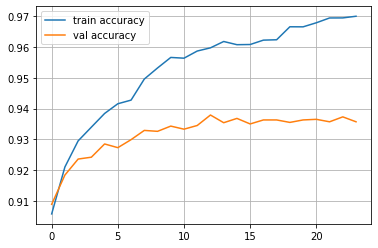

In [30]:
train_epochs(25)

## Разбор простейшего примера

https://www.youtube.com/watch?v=HA-F6cZPvrg

### Forward

In [31]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))
  
def sigmoid_dx(x):
  return x * (1 - x)

In [32]:
X = np.array([[1, 1, 0]])
y = 0

In [33]:
W = np.array([ [0.79, 0.85], [0.44, 0.43], [0.43, 0.29]])

In [34]:
XW = np.dot(X, W)
print(XW)
layer_2 = np.array([sigmoid(xw) for xw in XW])
print(layer_2)

[[1.23 1.28]]
[[0.77381857 0.78244978]]


In [35]:
W2 = np.array([ [0.5], [0.52] ])

In [36]:
LW2 = np.dot(layer_2, W2)
print(LW2)
layer_output = np.array([sigmoid(xw) for xw in LW2])
print(layer_output)

[[0.79378317]]
[[0.68864307]]


In [37]:
class TestLayer():
    def __init__(self, W):
        self.learning_rate = 0.1
        self.weights = W
        
    def forward(self,input):
        return sigmoid(np.dot(input, self.weights)) #+ self.biases
    
    def backward(self,input,grad_output):
        print(f'Исходный grad_output: {grad_output}')
        
        print('Исходные нейроны:')
        print(input.T)

        print('Исходные веса:')
        print(self.weights)
        
        
        grad_weights = np.dot(input.T, grad_output)

        self.weights = self.weights - self.learning_rate * grad_weights
        grad_input = np.dot(grad_output, self.weights.T)
        print('Скорректированные веса:')
        print(self.weights)
        print('-----')
        return grad_input

In [38]:
nw = []
nw.append(TestLayer(W))
nw.append(TestLayer(W2))

In [39]:
TL0 = X
TL1 = nw[0].forward(TL0)
TL2 = nw[1].forward(TL1)
print(TL0)
print(TL1)
print(TL2)

[[1 1 0]]
[[0.77381857 0.78244978]]
[[0.68864307]]


In [40]:
temp_x = X
print(temp_x)
for layer in nw:
  temp_x = layer.forward(temp_x)
  print(temp_x)

[[1 1 0]]
[[0.77381857 0.78244978]]
[[0.68864307]]


### Backward

In [41]:
actual = TL2
expected = y
error_2 = actual - expected

In [42]:
gradient_2 = sigmoid_dx(actual)
gradient_2

array([[0.21441379]])

In [43]:
weights_delta_2 = gradient_2 * error_2
weights_delta_2

array([[0.14765457]])

In [44]:
error_1 = nw[1].backward(TL1, weights_delta_2)
error_1

Исходный grad_output: [[0.14765457]]
Исходные нейроны:
[[0.77381857]
 [0.78244978]]
Исходные веса:
[[0.5 ]
 [0.52]]
Скорректированные веса:
[[0.48857421]
 [0.50844677]]
-----


array([[0.07214022, 0.07507449]])

In [45]:
gradient_1 = sigmoid_dx(TL1)
gradient_1

array([[0.17502339, 0.17022212]])

In [46]:
weights_delta_1 = gradient_1 * error_1
weights_delta_1

array([[0.01262623, 0.01277934]])

In [47]:
error_0 = nw[0].backward(TL0, weights_delta_1)
error_0

Исходный grad_output: [[0.01262623 0.01277934]]
Исходные нейроны:
[[1]
 [1]
 [0]]
Исходные веса:
[[0.79 0.85]
 [0.44 0.43]
 [0.43 0.29]]
Скорректированные веса:
[[0.78873738 0.84872207]
 [0.43873738 0.42872207]
 [0.43       0.29      ]]
-----


array([[0.02080488, 0.01101838, 0.00913529]])

### Test 

In [48]:
from tensorflow.keras.datasets.cifar10 import load_data
def load_dataset_cifar(flatten=False):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000].reshape(-1), y_train[-10000:].reshape(-1)

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

In [49]:
X_train_cifar, y_train_cifar, X_val_cifar, y_val_cifar, X_test_cifar, y_test_cifar = load_dataset_cifar(flatten=True)

In [50]:
X_train_cifar.shape

(40000, 3072)

In [51]:
X_train_cifar

array([[0.23137255, 0.24313725, 0.24705882, ..., 0.48235294, 0.36078431,
        0.28235294],
       [0.60392157, 0.69411765, 0.73333333, ..., 0.56078431, 0.52156863,
        0.56470588],
       [1.        , 1.        , 1.        , ..., 0.31372549, 0.3372549 ,
        0.32941176],
       ...,
       [0.65490196, 0.55294118, 0.43137255, ..., 0.63137255, 0.5254902 ,
        0.50980392],
       [0.17647059, 0.29803922, 0.49803922, ..., 0.24313725, 0.20784314,
        0.09411765],
       [0.92156863, 0.98823529, 0.98823529, ..., 0.63921569, 0.6627451 ,
        0.68235294]])

In [52]:
X_train_cifar[1].shape

(3072,)

In [53]:
y_train_cifar.shape

(40000,)

In [54]:
y_train_cifar

array([6, 9, 9, ..., 6, 2, 8], dtype=uint8)

In [55]:
network = []
network.append(Dense(X_train_cifar.shape[1],100,0.001,'adam'))
network.append(ReLU())
network.append(Dense(100,200,0.001,'adam'))
network.append(ReLU())
network.append(Dense(200,10,0.001,'adam'))

Epoch 24
Train accuracy: 0.3685
Val accuracy: 0.3511


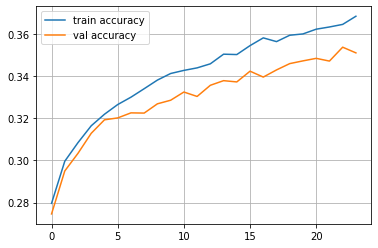

In [56]:
train_log = []
val_log = []

for epoch in range(1, 25):

    for x_batch,y_batch in iterate_minibatches(X_train_cifar,y_train_cifar,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch,epoch)
    
    train_log.append(np.mean(predict(network,X_train_cifar)==y_train_cifar))
    val_log.append(np.mean(predict(network,X_val_cifar)==y_val_cifar))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()